In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn

import librosa
import librosa.display
import IPython.display as ipd
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
import librosa
import librosa.display
from IPython.display import Audio
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, LSTM, Bidirectional, GRU, BatchNormalization, LeakyReLU
from keras.utils import to_categorical
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import os
import math
import json
import random

import numpy as np
import librosa
import json
import os
import soundfile as sf
import math
from keras.models import load_model
from datetime import datetime

In [ ]:
general_path = '/content/drive/MyDrive/Data'

# EDA on Music Audio Dataset

In [ ]:
print(list(os.listdir(f'{general_path}/genres_original/')))

['blues', 'rock', 'country', 'hiphop', 'classical', 'disco', 'jazz', 'reggae', 'pop', 'metal']


In [ ]:
y, sr = librosa.load(f'{general_path}/genres_original/disco/disco.00008.wav')

print('y:', y, '\n')
print('y shape:', np.shape(y), '\n')
print('Sample Rate (KHz):', sr, '\n')

print('Len of Audio:', 661794/22050)

y: [0.02011108 0.02133179 0.0241394  ... 0.32821655 0.18182373 0.07104492] 

y shape: (665060,) 

Sample Rate (KHz): 22050 

Len of Audio: 30.013333333333332


In [ ]:
audio_file, _ = librosa.effects.trim(y)

In [ ]:
print('Audio File:', audio_file, '\n')
print('Audio File shape:', np.shape(audio_file))

Audio File: [0.02011108 0.02133179 0.0241394  ... 0.32821655 0.18182373 0.07104492] 

Audio File shape: (665060,)


##  2D Spectrogram

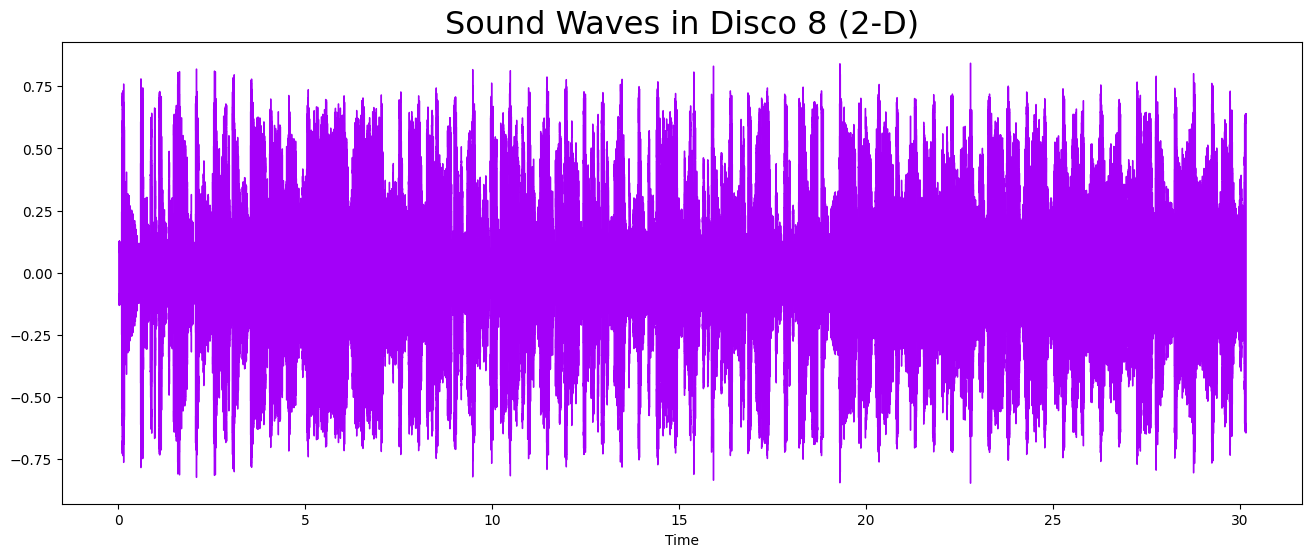

In [ ]:
plt.figure(figsize = (16, 6))
librosa.display.waveshow(y = audio_file, sr = sr, color = "#A300F9");
plt.title("Sound Waves in Disco 8 (2-D)", fontsize = 23);

## Fourier Transform

In [ ]:
n_fft = 2048
hop_length = 512

D = np.abs(librosa.stft(audio_file, n_fft=n_fft, hop_length=hop_length))

print('Shape of D object:', np.shape(D))

Shape of D object: (1025, 1299)


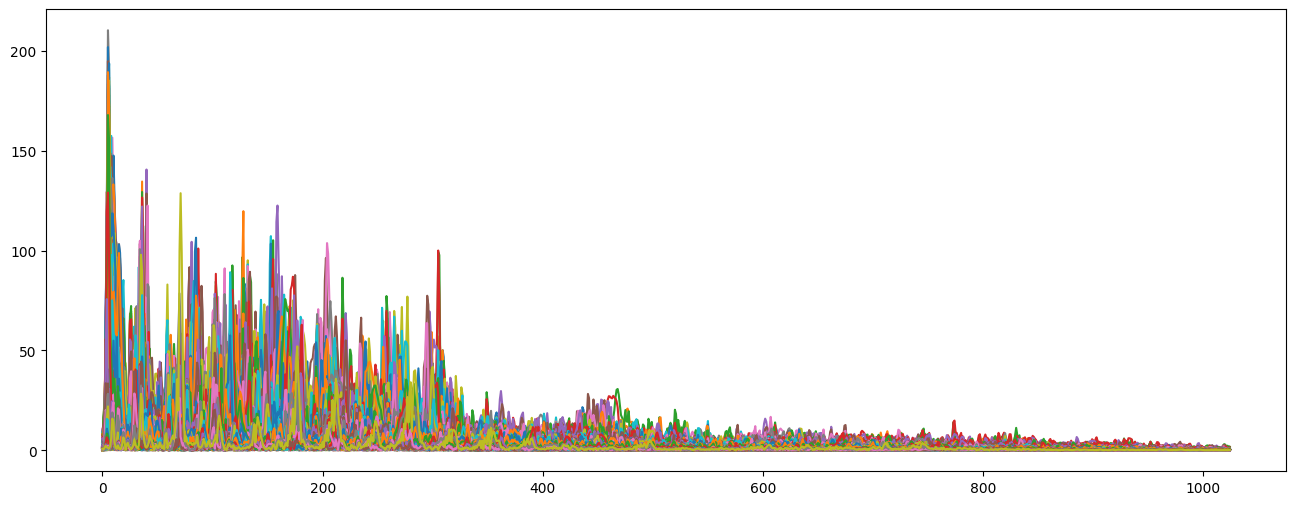

In [ ]:
plt.figure(figsize = (16, 6))
plt.plot(D);

## 3D Spectrogram

Text(0.5, 0.92, '3D Spectrogram')

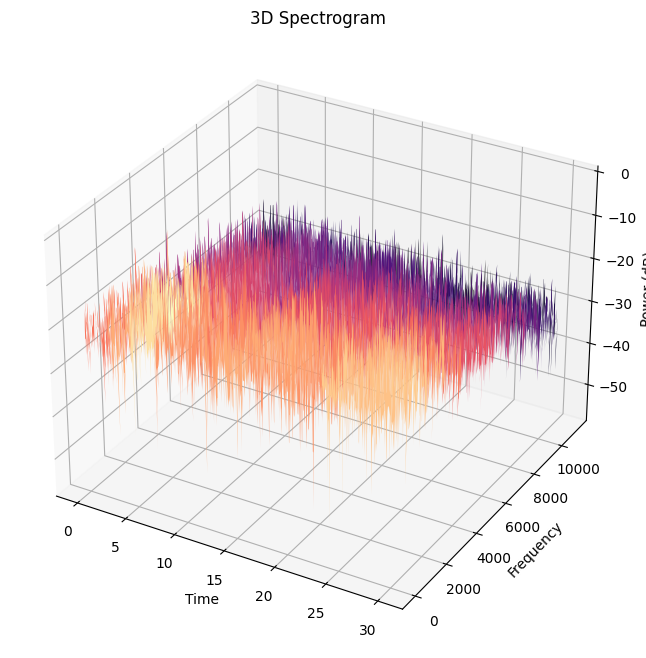

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

plt.figure(figsize=(12, 8))
X, Y = np.meshgrid(np.linspace(0, audio_file.shape[-1]/sr, num=D.shape[1]), np.linspace(0, 0.5 * sr, num=D.shape[0]))
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, librosa.power_to_db(D, ref=np.max), rstride=100, cstride=100, cmap='magma')
ax.set_xlabel('Time')
ax.set_ylabel('Frequency')
ax.set_zlabel('Power (dB)')
plt.title('3D Spectrogram')

## Spectrogram

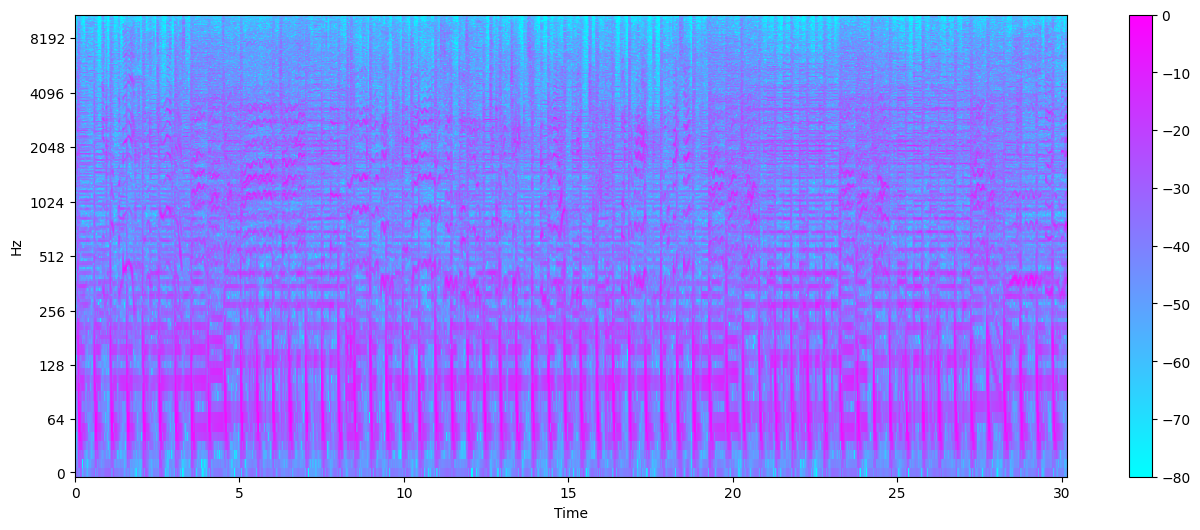

In [ ]:
DB = librosa.amplitude_to_db(D, ref = np.max)

plt.figure(figsize = (16, 6))
librosa.display.specshow(DB, sr = sr, hop_length = hop_length, x_axis = 'time', y_axis = 'log',
                        cmap = 'cool')
plt.colorbar();

#### Zero Crossing Rate: the rate at which the signal changes from positive to negative or back.

In [ ]:
zero_crossings = librosa.zero_crossings(audio_file, pad=False)
print(sum(zero_crossings))

109408


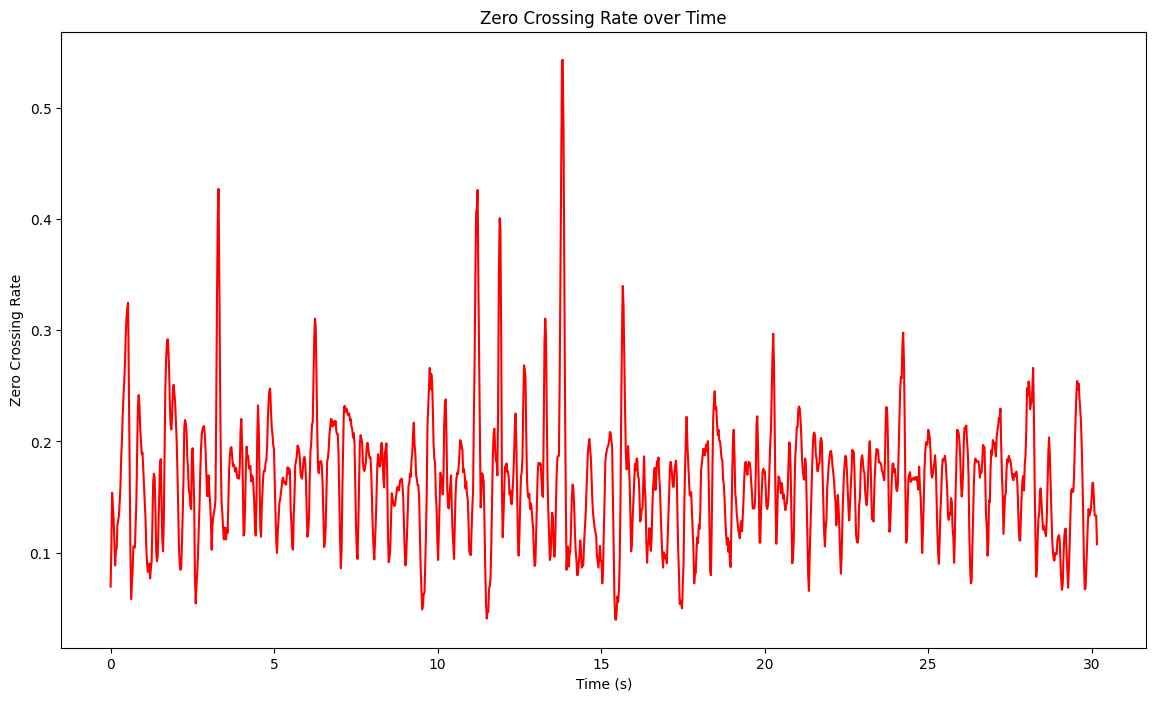

In [ ]:
zcr = librosa.feature.zero_crossing_rate(audio_file, frame_length=n_fft, hop_length=hop_length)[0]

plt.figure(figsize=(14, 8))
plt.plot(np.linspace(0, len(audio_file)/sr, len(zcr)), zcr, color='r')
plt.xlabel('Time (s)')
plt.ylabel('Zero Crossing Rate')
plt.title('Zero Crossing Rate over Time')
plt.show()

#### spectrogram

Text(0.5, 1.0, 'Spectrogram (dB)')

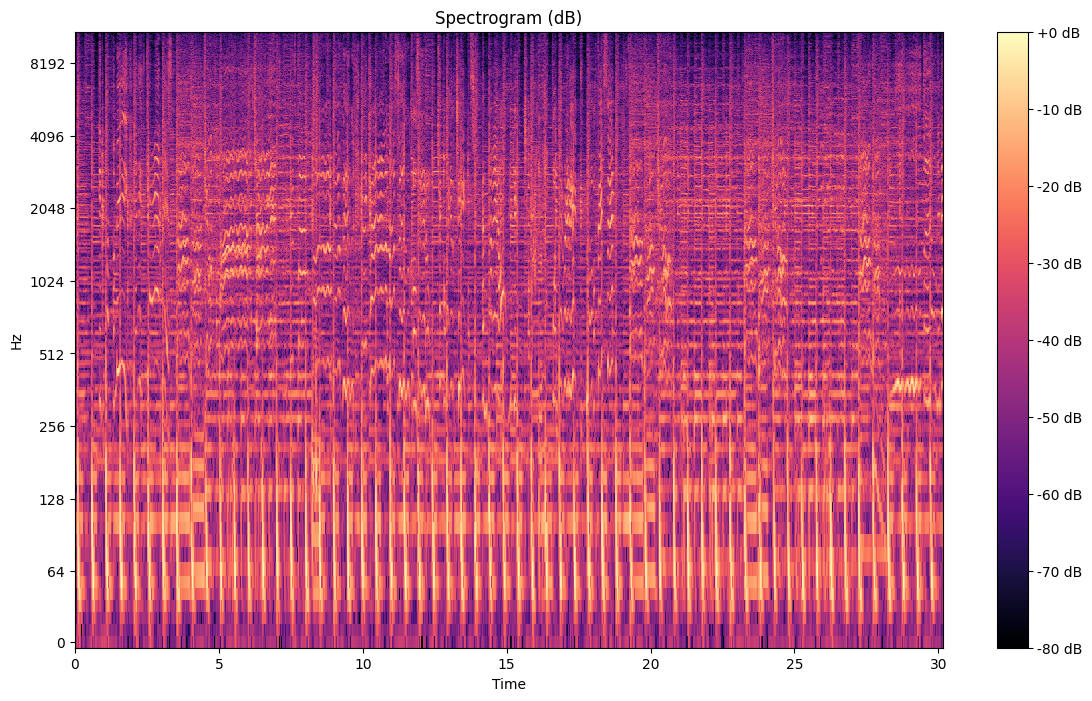

In [ ]:
plt.figure(figsize=(14, 8))
librosa.display.specshow(librosa.amplitude_to_db(D, ref=np.max), y_axis='log', x_axis='time', sr=sr)
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram (dB)')

#### Mel Spectrogram

Text(0.5, 1.0, 'Mel Spectrogram (dB)')

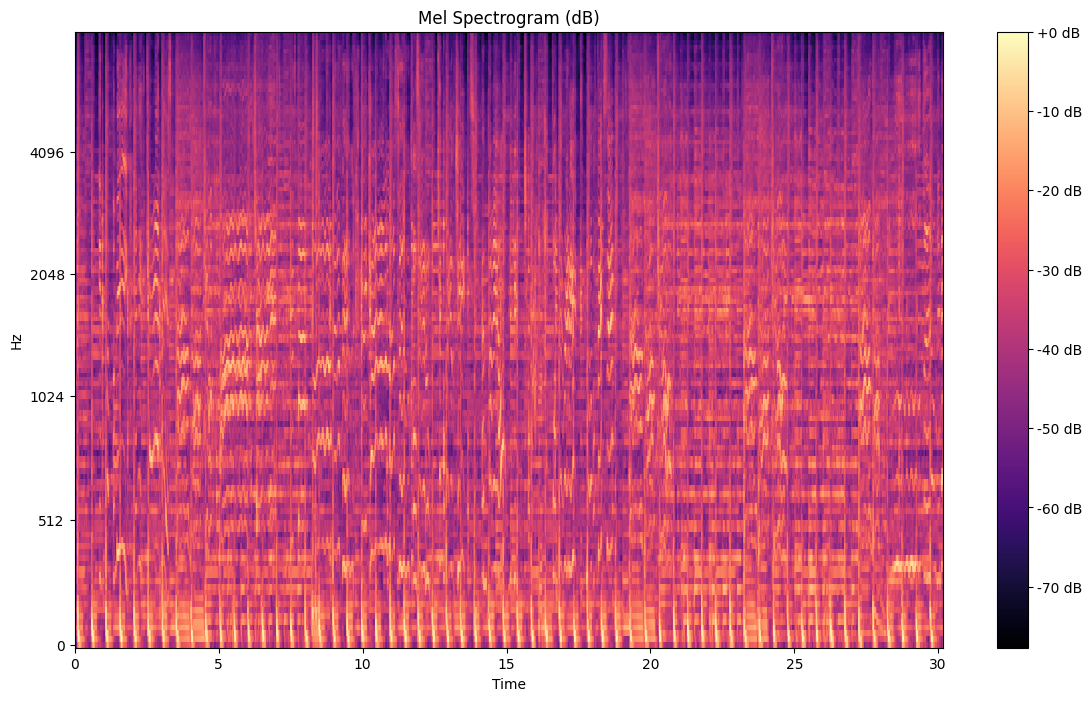

In [ ]:
mel_spect = librosa.feature.melspectrogram(y=audio_file, sr=sr, n_fft=n_fft, hop_length=hop_length)
plt.figure(figsize=(14, 8))
librosa.display.specshow(librosa.power_to_db(mel_spect, ref=np.max), y_axis='mel', fmax=8000, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram (dB)')

#### Rhythm Features

Text(0.5, 1.0, 'Rhythm Features')

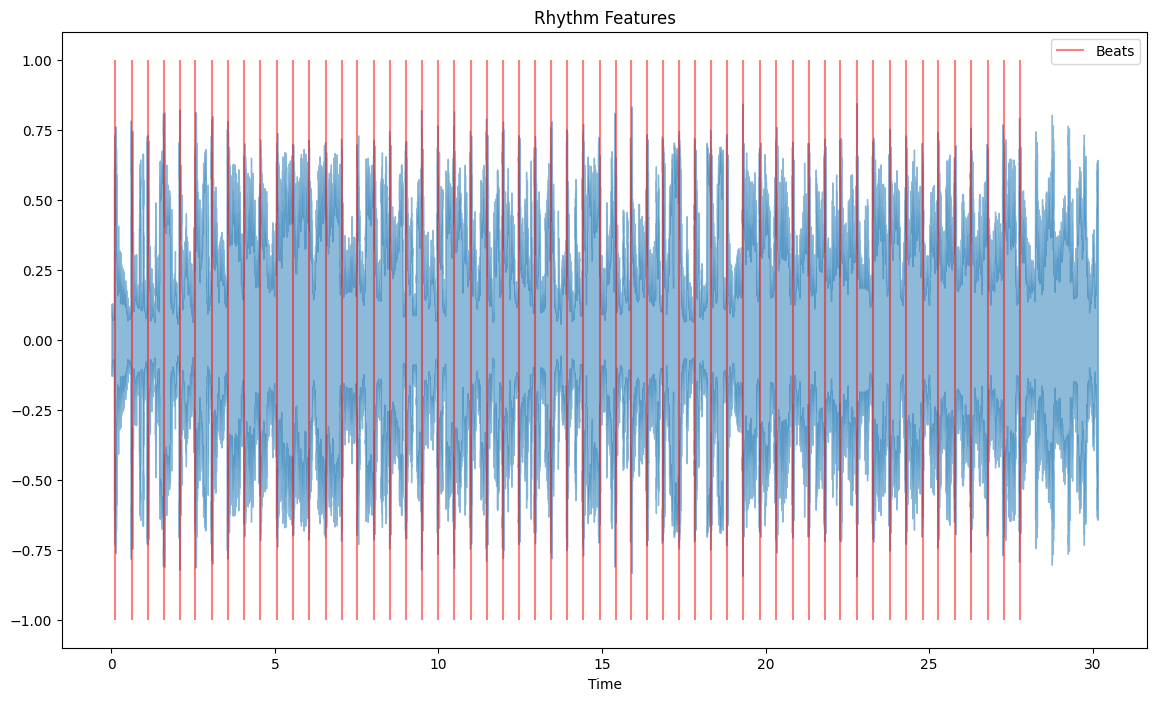

In [ ]:
tempo, beat_frames = librosa.beat.beat_track(y=audio_file, sr=sr)
beat_times = librosa.frames_to_time(beat_frames, sr=sr)

plt.figure(figsize=(14, 8))
librosa.display.waveshow(audio_file, sr=sr, alpha=0.5)
plt.vlines(beat_times, -1, 1, color='r', alpha=0.5, label='Beats')
plt.legend()
plt.title('Rhythm Features')

# LSTM Implementation

In [ ]:
Audio(f'{general_path}/genres_original/disco/disco.00004.wav')

In [ ]:
signal, sr = librosa.load(f'{general_path}/genres_original/blues/blues.00000.wav', sr=22050)

In [ ]:
print('Length of Signal is => ', len(signal))
print('Sampling Rate => ', sr)
print('Duration of the audio file => ', len(signal)/sr)

Length of Signal is =>  661794
Sampling Rate =>  22050
Duration of the audio file =>  30.013333333333332


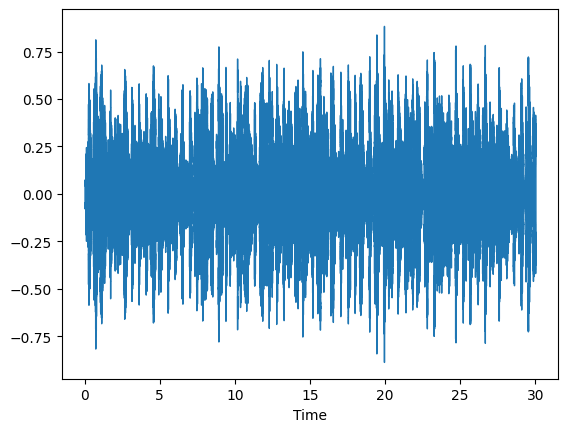

In [ ]:
librosa.display.waveshow(signal, sr=sr)

In [ ]:
DATASET_PATH = general_path
JSON_PATH = './data.json'
SAMPLE_RATE = sr =  22050
DURATION = 30
SAMPLES_PER_TRACK = SAMPLE_RATE * DURATION

## Extract MFCC(Mel Frequency Spectral Coefficients)

These MFCC's will act as our input features which we will pass through our model.

In [ ]:
def save_mfcc(dataset_path, json_path, n_mfcc=13, n_fft=4084, hop_length=1024, num_segments=10):
    data = {
        'mapping' : [],
        'mfcc' : [],
        'labels' : []
    }

    count = 0
    num_samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
    expected_num_mfcc_vectors_per_segment = math.ceil(num_samples_per_segment / hop_length)

    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):
        if dirpath not in dataset_path:
            dirpath_components = dirpath.split('/')
            semantic_label = dirpath_components[-1]
            data['mapping'].append(semantic_label)
            print('\nProcessing {}'.format(semantic_label))

            for f in filenames:
                if f.endswith('.wav') and f != 'jazz.00054.wav':
                    file_path = os.path.join(dirpath, f)
                    signal, sr = sf.read(file_path)

                    for s in range(num_segments):
                        start_sample = num_samples_per_segment * s
                        finish_sample = num_samples_per_segment + start_sample

                        mfcc = librosa.feature.mfcc(y=signal[start_sample:finish_sample],sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)

                        mfcc = mfcc.T

                        if len(mfcc) == expected_num_mfcc_vectors_per_segment:
                            print(mfcc.shape)
                            data['mfcc'].append(mfcc.tolist())
                            data['labels'].append(i)
                            print('Processing {}, segment:{}'.format(file_path, s))
                            count += 1
                            print(count)

    with open(json_path, 'w') as fp:
        json.dump(data, fp, indent=4)

In [ ]:
save_mfcc(DATASET_PATH, JSON_PATH, num_segments=10)

Streaming output truncated to the last 5000 lines.
8324
(65, 13)
Processing /content/drive/MyDrive/Data/genres_original/pop/pop.00023.wav, segment:5
8325
(65, 13)
Processing /content/drive/MyDrive/Data/genres_original/pop/pop.00023.wav, segment:6
8326
(65, 13)
Processing /content/drive/MyDrive/Data/genres_original/pop/pop.00023.wav, segment:7
8327
(65, 13)
Processing /content/drive/MyDrive/Data/genres_original/pop/pop.00023.wav, segment:8
8328
(65, 13)
Processing /content/drive/MyDrive/Data/genres_original/pop/pop.00023.wav, segment:9
8329
(65, 13)
Processing /content/drive/MyDrive/Data/genres_original/pop/pop.00019.wav, segment:0
8330
(65, 13)
Processing /content/drive/MyDrive/Data/genres_original/pop/pop.00019.wav, segment:1
8331
(65, 13)
Processing /content/drive/MyDrive/Data/genres_original/pop/pop.00019.wav, segment:2
8332
(65, 13)
Processing /content/drive/MyDrive/Data/genres_original/pop/pop.00019.wav, segment:3
8333
(65, 13)
Processing /content/drive/MyDrive/Data/genres_origina

In [ ]:
def load_data(path):
    with open(path, 'r') as fp:
        data = json.load(fp)

    inputs = data['mfcc']
    targets = data['labels']
    return np.array(inputs), np.array(targets)

In [ ]:
inputs, targets = load_data('./data.json')

In [ ]:
print(inputs)

[[[-122.59460258  133.18020052  -43.01039955 ...   12.3257299
    -10.56691618   -2.94827811]
  [ -84.14987184  133.03812922  -53.93201706 ...   10.11150237
    -11.95586695   -2.44932263]
  [ -40.47542089  143.68281758  -49.42227264 ...    4.38911523
     -0.9474593    -8.63760492]
  ...
  [ -11.12166817  149.08932087  -52.44900386 ...   -5.61927187
      6.1640432    -2.11036628]
  [ -31.70644408  160.24288328  -47.68101326 ...  -11.2534983
      3.38799445   10.05513249]
  [ -54.19366155  164.26533979  -50.83938652 ...  -16.90701963
     -0.28127441   16.14933397]]

 [[-103.8093265   156.76452629  -29.81438705 ...  -18.11817081
    -10.27853281   19.90075569]
  [ -91.7889561   162.00272963  -21.83016388 ...  -22.46504701
    -14.19073069   18.75389808]
  [-139.78158602  158.52432251   -6.34923473 ...  -23.70108866
    -15.41658781   12.28500485]
  ...
  [-186.74305201  145.68932451  -35.58373158 ...   -8.05537943
    -10.78906456   -2.0467014 ]
  [-147.9385306   147.16241275  -33.65

In [ ]:
print(targets)

[13 13 13 ... 22 22 22]


In [ ]:
inputs.shape

(9989, 65, 13)

In [ ]:
np.unique(targets, return_counts=True)

(array([13, 14, 15, 16, 17, 18, 19, 20, 21, 22]),
 array([1000, 1000, 1000,  999, 1000, 1000,  990, 1000, 1000, 1000]))

In [ ]:
v = min(np.unique(targets))

for i in range(len(targets)):
    if targets[i] == v:
        targets[i] = 0

    else:
        new = targets[i] - v
        targets[i] = new

In [ ]:
np.unique(targets, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([1000, 1000, 1000,  999, 1000, 1000,  990, 1000, 1000, 1000]))

In [ ]:
inputs_train, inputs_test, targets_train, targets_test = train_test_split(inputs, targets, test_size=0.25)

## Adding Noise

In [ ]:
for i in range(inputs_train.shape[0]):
    s = np.random.rand(inputs_train.shape[1], inputs_train.shape[2])
    inputs_train[i] = inputs_train[i] + s

In [ ]:
model = Sequential()

model.add(LSTM(200, return_sequences=True, input_shape=(inputs.shape[1], inputs.shape[2]), kernel_regularizer=l2(0.01)))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(LSTM(400, return_sequences=True, kernel_regularizer=l2(0.01)))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(LSTM(800, kernel_regularizer=l2(0.01)))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(LeakyReLU())
model.add(Flatten())
model.add(Dense(100, kernel_regularizer=l2(0.01)))
model.add(LeakyReLU())
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(10, activation='softmax'))

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
             loss = 'sparse_categorical_crossentropy',
             metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_35 (LSTM)              (None, 65, 200)           171200    
                                                                 
 dropout_29 (Dropout)        (None, 65, 200)           0         
                                                                 
 batch_normalization_21 (Ba  (None, 65, 200)           800       
 tchNormalization)                                               
                                                                 
 lstm_36 (LSTM)              (None, 65, 400)           961600    
                                                                 
 dropout_30 (Dropout)        (None, 65, 400)           0         
                                                                 
 batch_normalization_22 (Ba  (None, 65, 400)           1600      
 tchNormalization)                                    

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(f'{general_path}/best_model.h5', monitor='val_loss', save_best_only=True)

In [ ]:
history = model.fit(
    inputs_train,
    targets_train,
    validation_data = (inputs_test, targets_test),
    epochs = 100,
    batch_size = 64,
    callbacks = [early_stopping, model_checkpoint]
)

Epoch 1/100
118/118 [==============================] - 18s 93ms/step - loss: 7.8753 - accuracy: 0.4712 - val_loss: 4.5085 - val_accuracy: 0.3939
Epoch 2/100
118/118 [==============================] - 9s 73ms/step - loss: 3.3796 - accuracy: 0.5552 - val_loss: 2.9759 - val_accuracy: 0.4924
Epoch 3/100
118/118 [==============================] - 8s 70ms/step - loss: 2.5152 - accuracy: 0.5810 - val_loss: 2.2908 - val_accuracy: 0.5669
Epoch 4/100
118/118 [==============================] - 8s 71ms/step - loss: 2.1779 - accuracy: 0.6127 - val_loss: 2.1179 - val_accuracy: 0.5520
Epoch 5/100
118/118 [==============================] - 8s 70ms/step - loss: 2.0161 - accuracy: 0.6294 - val_loss: 1.8780 - val_accuracy: 0.6409
Epoch 6/100
118/118 [==============================] - 8s 72ms/step - loss: 1.7082 - accuracy: 0.6688 - val_loss: 1.8837 - val_accuracy: 0.5937
Epoch 7/100
118/118 [==============================] - 10s 82ms/step - loss: 1.6532 - accuracy: 0.6739 - val_loss: 1.7148 - val_accurac

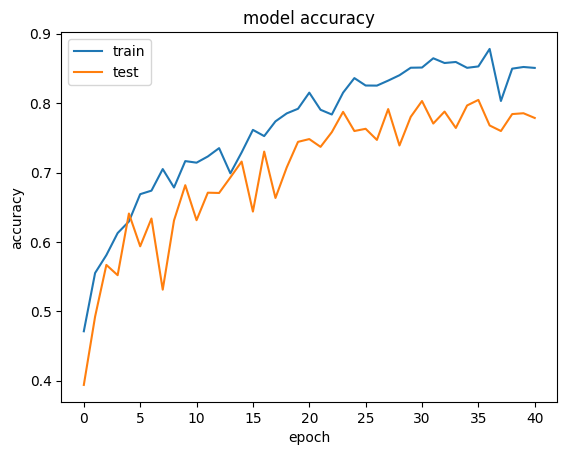

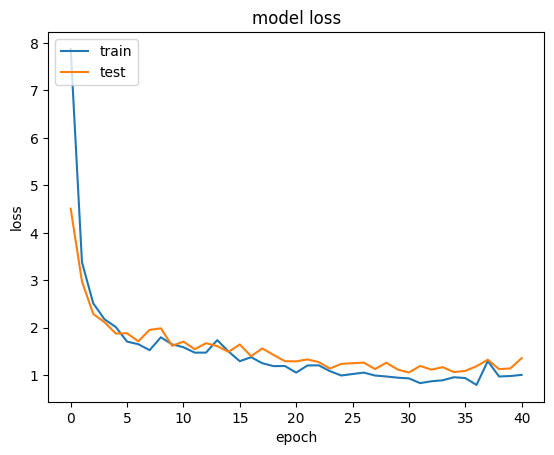

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Prediction

In [ ]:
general_path = "/content/drive/MyDrive/Data"
model = load_model(f'{general_path}/best_model.h5')

In [ ]:
def extract_mfcc(file_path, n_mfcc=13, n_fft=4084, hop_length=1024, num_segments=10):
    signal, sr = sf.read(file_path)
    SAMPLES_PER_TRACK = 22050 * 30
    num_samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
    expected_num_mfcc_vectors_per_segment = math.ceil(num_samples_per_segment / hop_length)

    mfccs = []
    start_time = datetime.now()
    st = start_time.strftime('%Y-%m-%d %H:%M:%S')
    print(f'MFCC Extraction for {file_path}\nStarting Extraction at {st}\n')

    for s in range(num_segments):
        print(f'Segment - ({s})')
        start_sample = num_samples_per_segment * s
        finish_sample = start_sample + num_samples_per_segment

        mfcc = librosa.feature.mfcc(y=signal[start_sample:finish_sample], sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)
        mfcc = mfcc.T

        if len(mfcc) == expected_num_mfcc_vectors_per_segment:
            mfccs.append(mfcc.tolist())

    end_time = datetime.now()
    et = end_time.strftime('%Y-%m-%d %H:%M:%S')
    total_time = end_time - start_time
    print(f'\nExtraction Successful\nCompleted at {et}\n\nExtraction Time - {total_time}')

    return np.array(mfccs)

In [ ]:
mapping = {
    0: 'Hiphop',
    1: 'Classical',
    2: 'Disco',
    3: 'Metal',
    4: 'Rock',
    5: 'Jazz',
    6: 'Country',
    7: 'Blues',
    8: 'Reggae',
    9: 'Pop'
}

In [ ]:
new_audio_path = f"{general_path}/country_download.wav"
Audio(new_audio_path)

In [ ]:
mfccs = extract_mfcc(new_audio_path)

MFCC Extraction for /content/drive/MyDrive/Data/country_download.wav
Starting Extraction at 2024-06-29 08:35:14

Segment - (0)
Segment - (1)
Segment - (2)
Segment - (3)
Segment - (4)
Segment - (5)
Segment - (6)
Segment - (7)
Segment - (8)
Segment - (9)

Extraction Successful
Completed at 2024-06-29 08:35:29

Extraction Time - 0:00:14.971673


In [ ]:
predictions = model.predict(mfccs)
predicted_label = np.argmax(predictions, axis=1)
pred_class = [mapping[pred] for pred in predicted_label]

print(f"Predicted label: {pred_class}")

1/1 [==============================] - 2s 2s/step
Predicted label: ['Country', 'Country', 'Country', 'Country', 'Country', 'Country', 'Country', 'Country', 'Country', 'Country']
